<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Cluster_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sklearn-lvq

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn_lvq import GlvqModel
from sklearn_lvq.utils import plot2d
from sklearn.mixture import GaussianMixture
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import statsmodels.api as sm
from sklearn_lvq import GlvqModel
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import math
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Para acomodar la información si viene por minuto y en registros, 
#df = pd.read_csv('rg1.csv')
## aqui agrupamos por minuto
#df_grouped_multiple = df.groupby(['YEAR','MONTH','DAY','HOUR']).agg({'RG1': ['mean']})
#df_grouped_multiple.columns = ['rg1_mean']
#df_grouped_multiple = df_grouped_multiple.reset_index()
## aquí pivoteamos
#df1 = df_grouped_multiple.pivot(index=['YEAR','MONTH','DAY'], columns='HOUR', values='rg1_mean').dropna()
#print(df1) #df1.to_csv('res.csv')
#df1.columns = [['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17', '18','19', '20', '21', '22', '23']]

In [ ]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,ytitle_,xtitle_,dot_,namefile_):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel(xtitle_, color=LETRASNARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    for p in serie_:
        if dot_== True:
           plt.plot(p,alpha=0.4, linestyle='dashed', linewidth=3)
        else:
           plt.plot(p,alpha=0.4)                
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [ ]:
def scatterplot(X_,Y_,tags_,centers_,title_,namefile_ ):
    fig, ax1 = plt.subplots(figsize=(4,4))
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
    for k in centers_:
        x = k[7]; y = k[8]
        plt.plot(x,y,"o",color="red",)
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('hora 7',  color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('hora 8',  color=LETRASNARA, fontsize='large')
    plt.scatter(X_, Y_, c=tags_, alpha=0.3)
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile_, transparent=True)
    plt.show()

In [ ]:
def print_patrones(list_series,list_categorias,list_patrones,title_,namefile_): 
    cat = np.unique(list_categorias)
    n = math.ceil(pow(n_clusters, 0.5))
    fig, axs = plt.subplots(n, n, figsize=(15,14))
    row=0; col=0
    for c in cat:
        j = 0
        for g in list_categorias:    
            if c == g:
                axs[row,col].plot(list_series[j],alpha=0.5)
                axs[row,col].set_title(title_+str(c),color = LETRASNARA)             
            j = j + 1

        axs[row,col].spines['bottom'].set_color(LETRASNARA)
        axs[row,col].spines['top'   ].set_color(LETRASNARA) 
        axs[row,col].spines['right' ].set_color(LETRASNARA)
        axs[row,col].spines['left'  ].set_color(LETRASNARA)
        axs[row,col].tick_params(colors = LETRASNARA, which='both')

        if len(list_patrones) != 0:
            axs[row, col].plot(list_patrones[c],alpha=0.7,color='red',linestyle='dashed',linewidth=4)

        col = col + 1
        if col == n:
            col = 0
            row = row + 1  
    plt.savefig(namefile_, transparent=True)
    plt.show()

# **Leemos datos fotovoltaicos**

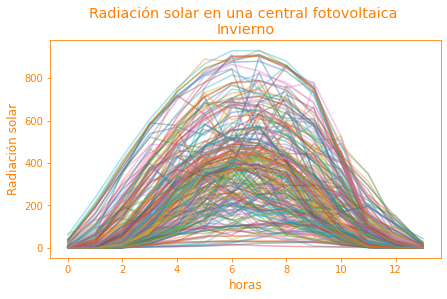

In [ ]:
df = pd.read_csv('rg1_horas.csv')

##totales por dia ('SUMA'), diferenciados de primer orden ('dSUMA'), de segundo orden ('ddSUMA')
x_total   = df[['SUMA']].to_numpy()
dx_total  = df[['dSUMA']].to_numpy()
ddx_total = df[['ddSUMA']].to_numpy()

## Por estación del año
df_invierno = df[(df.MONTH==11)|(df.MONTH==12)|(df.MONTH==1)|(df.MONTH==2)|(df.MONTH==3)|(df.MONTH==4)]
df_verano   = df[(df.MONTH==5) |(df.MONTH==6) |(df.MONTH==7)|(df.MONTH==8)|(df.MONTH==9)|(df.MONTH==10)]

opcion = 'Invierno'

if opcion =='Invierno':
    df = df_invierno
    horas_invierno =     ['5','6','7','8','9','10','11','12','13','14','15','16','17','18']
    X = df[horas_invierno].to_numpy()

if opcion =='Verano':
    df = df_verano
    horas_verano   = ['4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']
    X = df[horas_verano].to_numpy()

#Normalizing the data
#sc = StandardScaler()
#X  = sc.fit_transform(X)
#y  = sc.fit_transform(Y)

## Crea conjuntos de datos de entrenamiento y prueba.
X_train, X_test = train_test_split(X, test_size = 0.3)

print_serie(X_train,'Radiación solar en una central fotovoltaica \n'+opcion,'Radiación solar','horas',False,'fig_t13_'+opcion)

# **K-means**


y_kmeans [0 9 2 0 2 5 5 0 0 5 1 9 2 1 3 6 5 4 4 0 2 5 0 0 7 5 5 1 5 0 5 2 1 6 4 0 3
 7 6 4 6 4 9 3 5 5 5 5 6 0 0 5 2 6 1 0 2 6 6 5 4 2 6 0 2 5 4 0 5 5 3 6 6 1
 2 1 0 4 1 4 5 6 8 1 9 0 9 2 6 7 4 2 0 3 1 5 0 5 4 9 6 5 0 5 9 9 2 5] 108
y_kmeans_train [1 1 7 7 9 8 1 8 7 0 2 7 6 1 1 6 6 5 9 2 7 9 0 1 2 9 7 9 2 0 7 5 5 5 5 7 9
 9 0 7 5 5 6 0 4 3 5 5 3 5 0 2 0 5 0 5 6 4 3 4 9 2 6 2 8 0 4 7 6 5 2 0 3 2
 3 0 6 2 6 6 4 5 0 6 1 4 9 6 0 3 6 9 5 0 2 4 3 5 0 5 6 4 5 5 0 3 2 0 2 1 7
 3 3 2 5 3 5 7 5 1 3 5 9 4 6 6 5 2 0 4 0 5 0 7 2 1 5 9 5 7 4 0 3 4 5 4 0 5
 2 2 5 4 9 7 6 0 5 5 5 5 0 0 3 5 2 2 3 9 5 7 5 3 5 9 5 4 0 2 4 4 6 1 0 5 0
 5 0 7 0 0 0 0 2 4 4 3 0 4 3 0 2 6 0 6 5 2 6 5 0 5 5 0 2 2 5 2 4 9 0 2 5 6
 1 0 0 0 5 8 0 5 3 0 0 3 5 0 0 2 5 2 7 2 5 0 4 5 6 9 0 5 4 0] 252


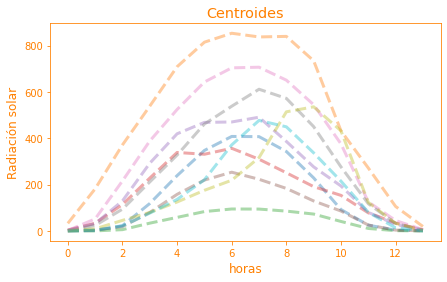

In [ ]:
n_clusters = 10
k_means = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, n_init=10) # una variante MiniBatchKMeans, KMeans
k_means = k_means.fit(X_train)
values  = k_means.cluster_centers_.squeeze()
labels  = k_means.labels_
kmeans_centers_= k_means.cluster_centers_
#print('Centroides', centers_)
#print('Exactitud:', k_means.score(X_test))
y_kmeans = k_means.predict(X_test)
y_kmeans_train = k_means.predict(X_train)
print('y_kmeans' , y_kmeans,len(y_kmeans ))
print('y_kmeans_train' , y_kmeans_train,len(y_kmeans_train))
print_serie(kmeans_centers_,'Centroides','Radiación solar','horas',True,'fig_t13_centroids_kmeans')
#scatterplot(X_train[:,4],X_train[:,8],labels,centers_,'Radiación solar \n K-means \n(entrenamiento)','fig_t13_train')

X_train (kmeans)


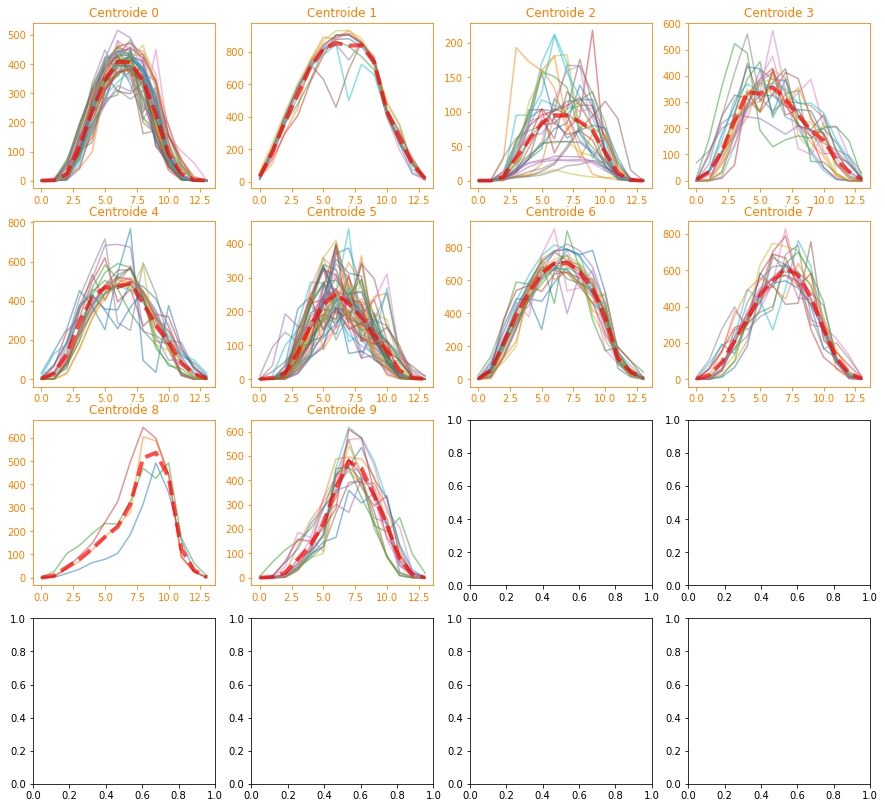

In [ ]:
print('X_train (kmeans)')
print_patrones(list_series=X_train,list_categorias=y_kmeans_train,list_patrones=kmeans_centers_,title_='Centroide ',namefile_='fig_t13_kmeans_train')

X_test (kmeans)


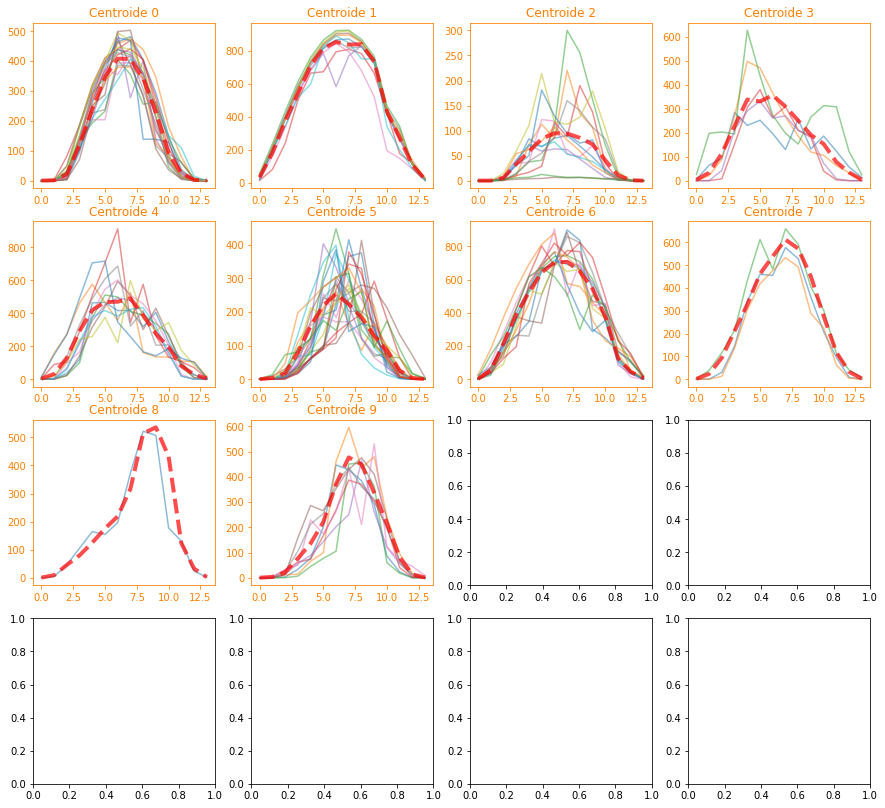

In [ ]:
print('X_test (kmeans)')
print_patrones(list_series=X_test,list_categorias=y_kmeans,list_patrones=kmeans_centers_,title_='Centroide ',namefile_='fig_t13_kmeans_test')

# **KNN from scratch**


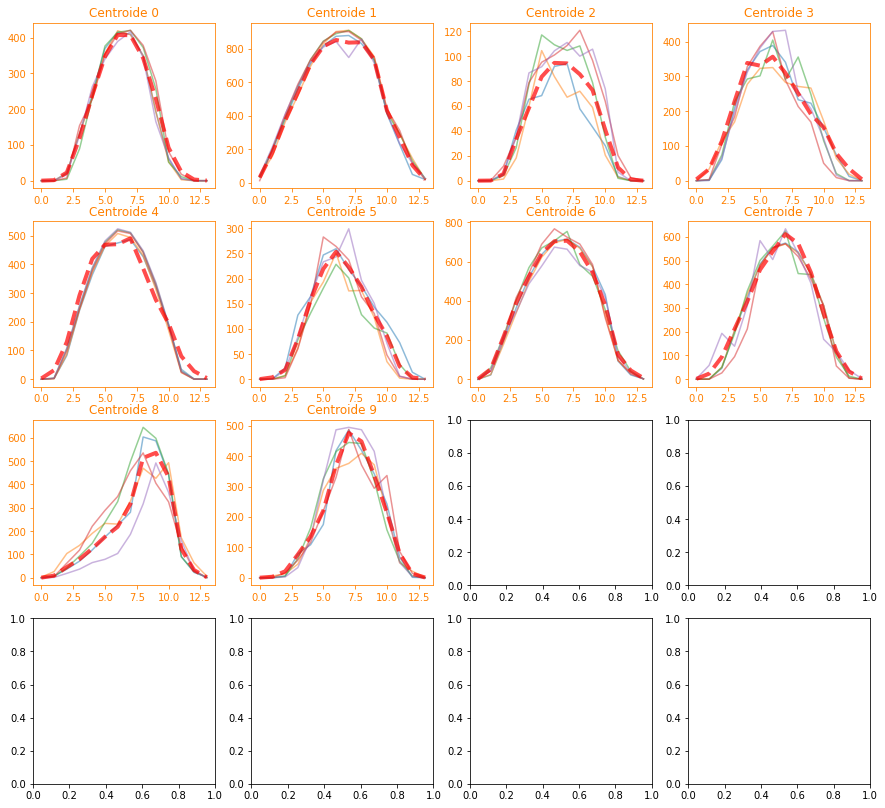

In [ ]:
#https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

## Encuentra los vecinos más cercanos
def get_neighbors(train, test_row, num_neighbors):
  
    distances = list()

    for train_row in train:
        dist = euclidean(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])

    neighbors = list()

    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

# Predecimos un elemento con KNN
def predict_classification(train, test_row, num_neighbors):
	  neighbors = get_neighbors(train, test_row, num_neighbors)
	  output_values = [row[-1] for row in neighbors]
	  prediction = max(set(output_values), key=output_values.count)
	  return prediction

dataset = [[2.7810836,2.550537003,0],	[1.465489372,2.362125076,0],	[3.396561688,4.400293529,0],	[1.38807019,1.850220317,0],[3.06407232,3.005305973,0],	[7.627531214,2.759262235,1],	[5.332441248,2.088626775,1],	[6.922596716,1.77106367,1],	[8.675418651,-0.242068655,1],[7.673756466,3.508563011,1]]
row0 = dataset[0]
#for row in dataset:
#	  distance = euclidean(row0, row)
#	  print(distance)
prediction = predict_classification(dataset, dataset[0], num_neighbors=10)
#neighbors = get_neighbors(dataset, dataset[0], 5)

serie = []
cat   = []
i     = 0 
for center in kmeans_centers_:
    neighbors = get_neighbors(X_train, center, num_neighbors=5)
    for neighbor in neighbors:
        serie.append(neighbor)
        cat.append(i)
    i = i  + 1
print_patrones(list_series=serie,list_categorias=cat,list_patrones=kmeans_centers_,title_='Centroide ',namefile_='fig_t13_knn_scratch')

# **KNN de aportaciones hidrológicas en presas**

position [623, 548, 609, 488, 236, 297, 716, 200, 633, 477]


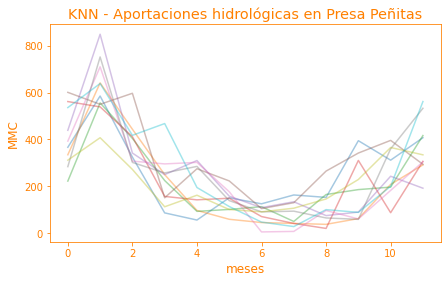

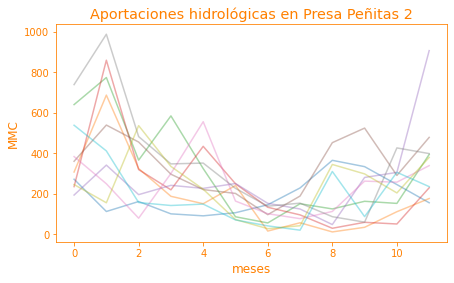

In [ ]:
df = pd.read_csv('Aportaciones_Embalses.csv')
apor = df['PEA'].to_numpy()
v = 12                    ## tamanio de la ventana (un año)
k = 10                    ## número de vecinos a buscar k
vecindario    = []        ## vecindario completo
vecindario_b  = [] 
distances     = []
n             = len(apor) ## longitud total de la serie
tol           = 0.8      ## tolerancia de tamaño de ventanas para seleccion de vecinos

n             = n - 12    ## datos de test (Comentar esta linea!!!)

#print(apor[n-v:n],'**')  ## imprime el prototipo
## Se calcula la distancia euclidiana entre todos los vecinos.
for i in range(n-2*v+1):
    dist = euclidean(apor[n-v:n],apor[i:i+v])
    distances.append((i, dist))
    #print(apor[n-v:n],apor[i:i+v],i, dist)

## Se ordena el vecindario por distancia de menor a mayor y se guardan las posiciones.
distances.sort(key=lambda tup: tup[1])
neighbors  = []
neighbors2 = []
position   = []

## Se escogen los k vecinos mas cercanos y guardamos las posiciones.
i = 0
for pos, dis in distances:
    #print(apor[pos:pos+v],dis,pos)

    if i==0:      
        position.append(pos)   
        neighbors.append(apor[pos:pos+v])
        neighbors2.append(apor[pos+v:pos+2*v])
    else:
        bandera = True
        for p in position:
            if (abs(pos - p) < tol*v):
                bandera = False
                i = i - 1
                break
        if bandera == True:
            #print(pos,p)
            position.append(pos)   
            neighbors.append(apor[pos:pos+v])
            neighbors2.append(apor[pos+v:pos+2*v])
            bandera = False
    i = i + 1
    if i == k:
        break

## Convertimos a numpy.  
neighbors  = np.array(neighbors)
neighbors2 = np.array(neighbors2)
print('position',position)    ## posición de los k vecinos mas cercanos.
#print(neighbors)   ## k vecinos mas cercanos.
#print(neighbors2)  ## ventana de datos posterior a los k vecinos mas cercanos.

print_serie(neighbors, 'KNN - Aportaciones hidrológicas en Presa Peñitas','MMC','meses', False,'fig_t13_aportaciones')
print_serie(neighbors2,'Aportaciones hidrológicas en Presa Peñitas 2','MMC','meses', False,'fig_t13_aportaciones2')

In [ ]:
X   = sm.add_constant(neighbors.T)
X_2 = sm.add_constant(neighbors2.T)
y   = apor[n-v:n]

y_real = apor[n-v +12:n +12]
print('y_real',y_real)

model   = sm.OLS(y, X)
results = model.fit()
result_prediction = results.predict(X_2)
#print(result_prediction)
#print(results.summary())

## Se ordenan los valores p y se selecciona el más grande.
i = 0
pvalues = []
for pi in results.pvalues:
    pvalues.append((i,pi))
    i = i + 1
pvalues.sort(key=lambda tup: tup[1])
(i, pi) = pvalues[0]

## Proceso de stepwise
while pi > 0.01:
    #print( X )
    X   = sm.add_constant(X)
    X_2 = sm.add_constant(X_2) 
    print('Retiramos regresor X' + str(i))
    X   = np.delete(arr=X,   obj=i+0, axis=1)
    X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
    #print( X )
    model   = sm.OLS(y, X)
    results = model.fit()

    ## Se ordenan los valores p y se selecciona el más grande
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1])
    (i, pi) = pvalues[0]
    #print(pi)

#print(X_2)
result_prediction = results.predict(X)
result_prediction_2 = results.predict(X_2)
print('result_train',  result_prediction)
print('result_prediction_2',result_prediction_2)
print(results.summary())

# Exactitud del modelo
print('Test MAE OLS + stepwise= ', mean_absolute_error(y,y_real))

y_real [574.57 311.47 321.42  70.76  67.52 123.29  32.41 192.81 102.69  95.95
 471.78 831.13]
Retiramos regresor X1
Retiramos regresor X8
Retiramos regresor X5
Retiramos regresor X3
Retiramos regresor X2
Retiramos regresor X1
Retiramos regresor X1
Retiramos regresor X2
Retiramos regresor X1
result_train [465.67952492 544.31117768 374.9389042  413.41170116 204.26376708
 142.10950745  91.14454733  76.50649111 131.91651542 122.949748
 208.17235801 485.37575763]
result_prediction_2 [467.97869606 370.72375712 175.14093273 163.95163321 169.23972682
 109.30799928  86.77612217  70.45200713 292.85849475 121.87680147
 289.7162942  235.45585545]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     16.45
Date:                Sat, 23 Apr 2022   P

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


No handles with labels found to put in legend.


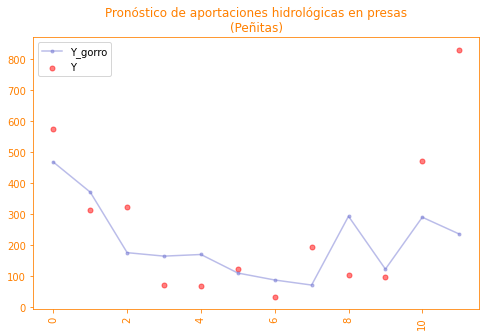

In [ ]:
fig  = plt.figure(figsize=(8,5))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Pronóstico de aportaciones hidrológicas en presas\n(Peñitas)') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                        #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(y_real) )
plt.scatter( AUX, y_real,s=25,marker='o', color = 'red', label = 'Y', alpha=1/2)
axes.plot  ( result_prediction_2 ,   '.-' , color = LILA  , label = 'Y_gorro'   ,alpha=1/2)
#axes.plot  ( y_pred_poly,  '.-' , color = VERDE , label = 'SVM poly'   ,alpha=1/2)
#axes.plot  ( y_pred_linear, '.-' , color = AZUL , label = 'SVM linear'   ,alpha=1/2)
#axes.plot  ( y_local_list[1], '.-' , color = VERDE      , label = 'Y_local,k=25'   ,alpha=1/2)
#axes.plot  ( y_local_list[2], '.-' , color = AZUL       , label = 'Y_local,k=35'   ,alpha=1/2)
#axes.plot  ( y_local_list[3], '.-' , color = LILA       , label = 'Y_local,k=50'   ,alpha=1/2)
#axes.plot  ( y_local_list[4], '.-' , color = CYAN       , label = 'Y_local,k=100'  ,alpha=1/2)
#axes.plot  ( y_lineal         , '--' , color = 'red'      , label = 'lineal'       ,alpha=1/2)
#axes.plot ( y      , '.-'  , color = 'red'        , label = 'Y'  ,alpha=1/2)
#axes.plot ( y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
#axes.plot ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

#plt.axis([0,  600, 7650, 9800])
#plt.axis([100,  200, 7650, 9500])
#plt.axis([400,  500, 7450, 9500])
#plt.axis([-2,  100, 8100, 9600])
#plt.axis([300, 400, 7900, 9500])

axes.spines['bottom'].set_color(LETRASNARA)
axes.spines['top'   ].set_color(LETRASNARA) 
axes.spines['right' ].set_color(LETRASNARA)
axes.spines['left'  ].set_color(LETRASNARA)
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('fig_t13_aportaciones_prono3.png', transparent=True)
plt.show()

# **LVQ**

In [ ]:
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_rslvq.html
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/index.html
#https://mrnuggelz.github.io/sklearn-lvq/modules/generated/sklearn_lvq.GlvqModel.html#sklearn_lvq.GlvqModel
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_glvq.html#sphx-glr-auto-examples-plot-glvq-py

print('GLVQ')
glvq = GlvqModel(prototypes_per_class=1, initial_prototypes=None)
glvq.fit(X_train,labels)
glvq_pred = glvq.predict(X_test)
glvq_pred_train = glvq.predict(X_train)
print('glvq_pred',glvq_pred)
print('glvq_pred_train', glvq_pred_train)
print('classification accuracy:', (glvq.score(X_test, glvq_pred)))

GLVQ
glvq_pred [0 9 2 0 2 5 5 0 0 5 1 9 5 1 3 6 5 4 4 0 2 5 0 0 7 5 5 1 5 0 5 2 1 6 4 0 3
 0 6 4 6 4 9 3 5 5 5 5 6 0 0 5 2 6 1 0 2 6 6 5 7 2 6 0 5 5 4 0 5 5 0 6 6 1
 2 1 0 4 1 9 5 6 8 1 9 0 9 2 6 7 4 2 0 3 1 5 0 5 4 9 6 5 0 5 9 9 2 5]
glvq_pred_train [1 1 7 7 9 8 1 8 7 0 2 7 6 1 1 6 6 5 9 2 7 9 0 1 2 9 7 9 2 0 7 5 5 5 5 7 9
 9 0 7 5 5 6 0 4 3 5 5 5 5 0 2 0 5 5 5 6 4 3 4 9 2 6 2 8 0 4 7 6 5 2 0 3 2
 0 0 6 2 6 6 4 5 0 6 1 4 9 6 0 3 6 9 5 0 2 4 3 5 0 5 6 4 5 5 0 3 2 0 2 1 7
 3 5 2 5 3 5 6 5 1 3 5 9 4 6 6 5 2 0 4 0 5 0 7 2 1 5 9 5 7 3 0 3 4 5 3 0 5
 2 2 5 4 9 7 6 0 5 5 5 5 0 0 3 5 2 5 3 9 5 7 5 3 5 9 5 4 0 2 4 4 6 1 0 5 0
 5 0 7 0 0 0 0 2 4 4 3 0 4 3 0 2 6 0 6 5 2 6 5 0 5 5 0 2 2 5 2 4 9 0 2 5 6
 1 0 0 0 5 8 0 5 3 0 0 3 5 0 0 5 5 5 7 2 5 0 4 5 6 0 0 5 4 0]
classification accuracy: 1.0


X_train (LVQ)


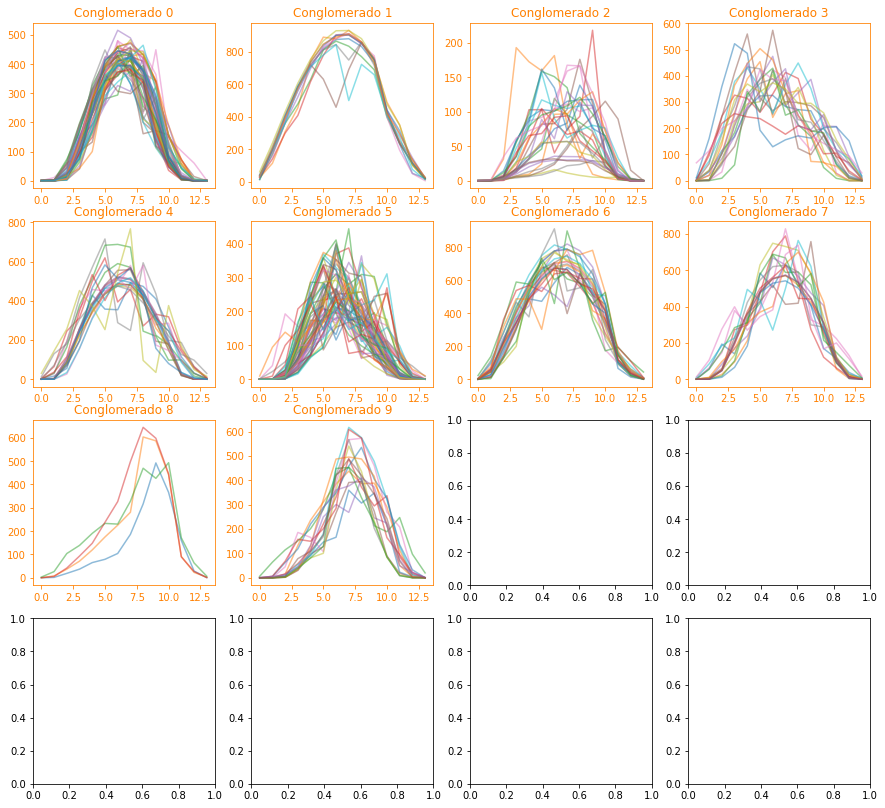

In [ ]:
print('X_train (LVQ)')
print_patrones(list_series=X_train,list_categorias=glvq_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_lvq_train')

X_test (LVQ)


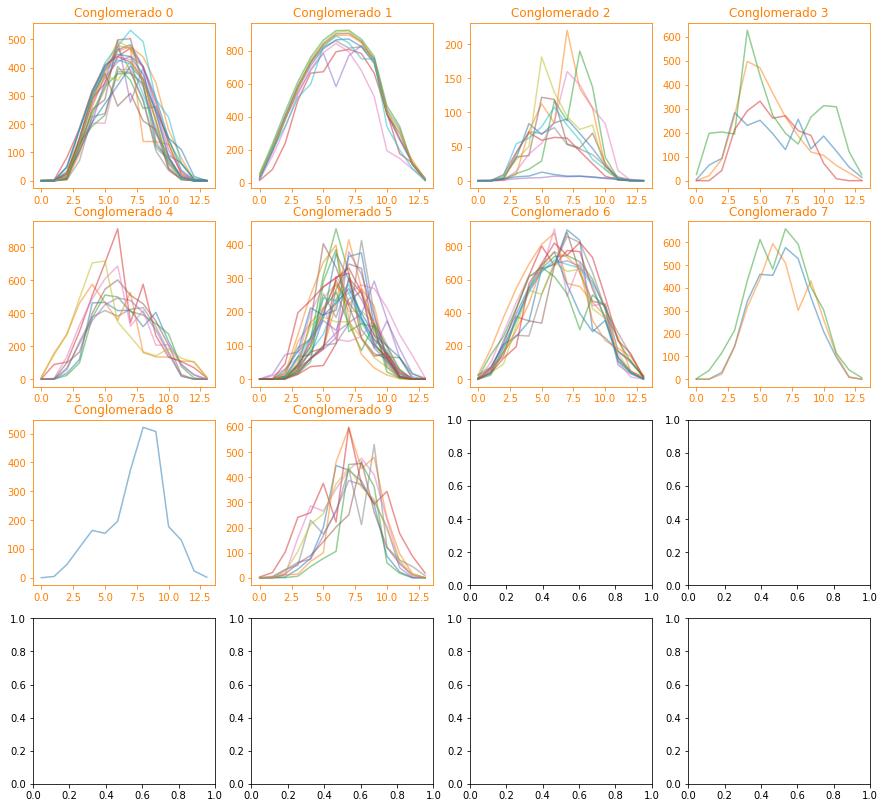

In [ ]:
print('X_test (LVQ)')
print_patrones(list_series=X_test,list_categorias=glvq_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_lvq_test')

# **GaussianMixture**

In [ ]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
gm = GaussianMixture(n_components=n_clusters, init_params='kmeans',covariance_type='full') #full, tied, diag, spherical
gm.fit(X_train)
gm_pred_train = gm.predict(X_train)
gm_pred       = gm.predict(X_test)

print('classification accuracy train:', gm.score(X_train, gm_pred_train))
print('classification accuracy:', gm.score(X_test, gm_pred))

print('gm_pred',gm_pred)
print('gm_pred_train', gm_pred_train)

classification accuracy train: -43.88790685985438
classification accuracy: -168.42383096796755
gm_pred [1 1 1 1 1 1 1 1 3 3 0 2 1 2 2 2 1 0 0 1 1 1 1 1 0 2 1 2 1 1 1 1 2 0 1 2 2
 1 2 2 2 3 1 0 1 1 1 1 2 0 1 1 1 2 0 1 1 2 2 1 1 1 0 1 1 1 2 1 1 1 1 2 0 2
 1 0 1 2 0 2 1 2 0 2 0 1 1 1 2 0 3 1 1 1 0 1 1 1 2 1 2 1 1 0 0 3 1 1]
gm_pred_train [5 5 0 1 1 7 5 7 0 1 6 0 2 5 5 2 2 1 1 1 0 7 1 5 1 7 0 1 6 1 0 1 1 1 1 0 1
 7 1 2 1 1 2 1 0 3 1 9 3 1 1 6 1 1 1 3 2 3 3 0 1 1 2 1 7 1 4 0 2 1 6 1 3 6
 1 1 2 6 2 2 3 1 1 2 5 3 1 2 3 4 2 7 9 1 1 0 3 9 1 1 2 4 1 1 3 4 6 7 1 5 1
 3 1 6 1 4 1 0 1 5 3 1 7 3 2 2 1 6 1 3 1 1 1 0 6 5 1 1 1 2 4 1 4 3 1 4 1 1
 1 6 1 3 1 0 2 3 9 1 1 1 1 1 3 9 6 1 9 7 9 1 1 4 9 7 1 0 1 1 0 3 2 5 1 1 3
 1 1 1 1 1 1 1 1 3 1 3 1 4 4 1 1 2 1 2 9 6 2 1 1 1 1 1 1 1 1 6 8 1 1 6 1 2
 5 1 1 1 1 7 1 1 3 1 1 4 9 1 1 1 1 1 0 6 1 1 1 1 2 1 1 9 0 1]


X_train (GaussianMixture)


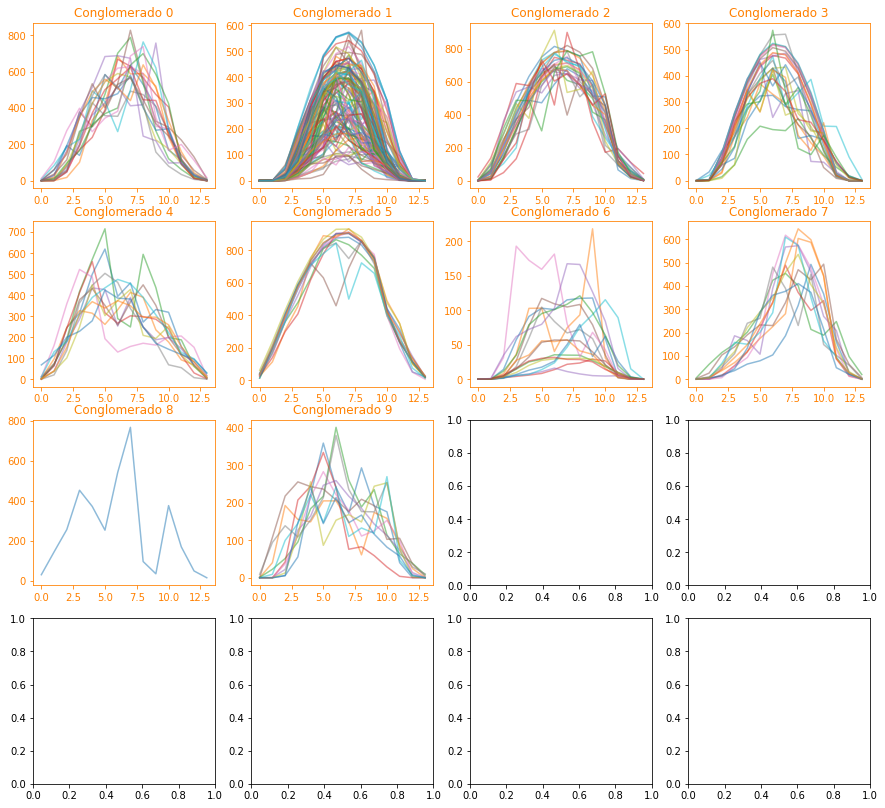

In [ ]:
print('X_train (GaussianMixture)')
print_patrones(list_series=X_train,list_categorias=gm_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_gm_train')

X_test (GaussianMixture)


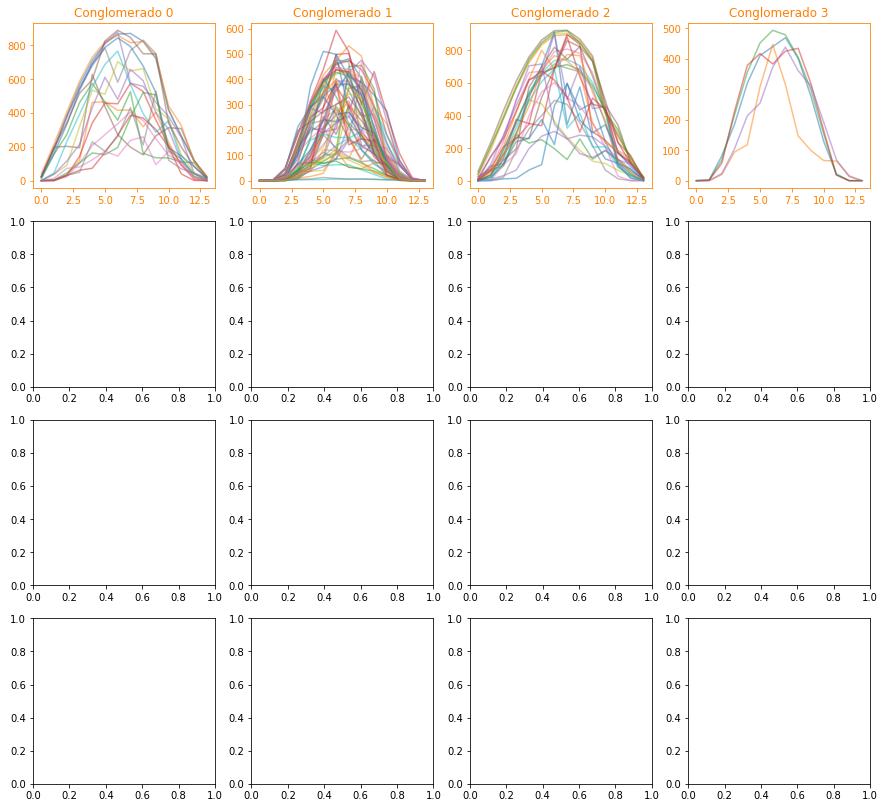

In [ ]:
print('X_test (GaussianMixture)')
print_patrones(list_series=X_test,list_categorias=gm_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_gm_test')

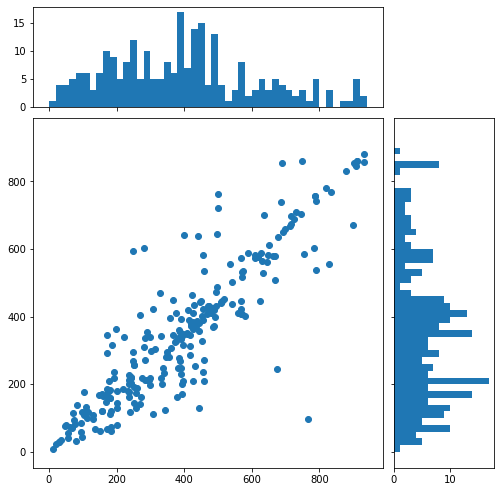

In [ ]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    ax.scatter(x, y)
    # now determine nice limits by hand:
    binwidth = 20
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# use the previously defined function
scatter_hist(X_train[:,7],X_train[:,8], ax, ax_histx, ax_histy)

plt.show()

# **KNN**

In [ ]:
#https://scikit-learn.org/stable/modules/neighbors.html#classification
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(X_train)  #['auto','ball_tree','kd_tree','brute'].
distances, indices = nbrs.kneighbors(X_train)
print(distances, indices)
nbrs.kneighbors_graph(X_train).toarray()

[[  0.          70.32779597 122.17993103 ... 202.25447456 224.46754653
  234.04546988]
 [  0.         157.39849286 205.41961601 ... 254.85833919 262.15172929
  311.27490001]
 [  0.         240.8298795  263.06074871 ... 291.39787711 292.3741814
  301.72892135]
 ...
 [  0.         144.27991125 154.72193162 ... 173.74236757 178.20129927
  179.46405633]
 [  0.         170.90361077 189.71458468 ... 261.00805016 264.31155752
  269.60683414]
 [  0.          59.66517693  65.46405706 ... 119.84019218 125.65871435
  131.88223279]] [[  0  84 222 ... 119  13   1]
 [  1  14 222 ...  84   6 109]
 [  2 153 169 ...  35   3 143]
 ...
 [249  81 174 ... 207 242 114]
 [250  59  85 ...  57 179 123]
 [251  43 161 ... 189   9  52]]


array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, labels)
knn_pred_train = knn.predict(X_train)
knn_pred       = knn.predict(X_test)
print('knn_pred', knn_pred)
print('knn_pred_train',knn_pred_train )
print(knn.score(X_test,knn_pred))

knn_pred [0 9 2 0 2 5 5 0 0 0 1 9 5 1 5 6 5 0 3 0 2 5 0 0 4 5 5 1 5 0 5 2 6 6 4 0 3
 0 6 6 6 4 9 3 5 5 5 5 6 0 0 5 2 6 1 0 2 6 6 5 0 2 6 0 2 5 4 0 5 5 5 6 6 1
 2 6 0 4 1 9 5 6 9 1 9 0 5 2 6 7 0 2 0 5 1 5 0 5 3 0 6 0 0 5 9 0 2 5]
knn_pred_train [1 1 7 7 9 5 1 9 7 0 2 4 6 1 1 6 6 5 9 2 7 0 0 1 2 9 7 9 2 0 7 5 5 5 5 4 9
 9 0 6 5 5 6 0 4 3 5 5 5 5 0 2 0 5 0 5 6 4 3 4 9 2 6 2 9 0 4 7 6 5 2 0 0 2
 0 0 6 2 6 6 4 5 0 6 1 4 9 6 0 3 6 9 5 0 2 4 0 5 0 5 6 4 5 5 0 3 2 0 2 1 0
 3 5 2 5 3 0 6 5 1 0 5 9 4 6 6 5 2 0 4 0 5 0 7 2 1 5 0 5 7 3 0 3 4 5 3 0 5
 2 2 5 4 9 4 6 0 5 5 5 5 0 0 3 5 2 2 5 9 5 7 5 3 5 9 5 4 0 2 4 4 6 1 0 5 0
 5 0 7 0 0 0 0 2 4 4 3 0 4 3 0 2 6 0 6 5 2 6 5 0 5 5 0 2 2 5 2 4 9 0 2 5 6
 1 0 0 0 5 9 0 5 3 0 0 3 5 0 0 2 5 2 4 2 5 0 0 5 6 0 0 5 4 0]
1.0


X_train (KNN)


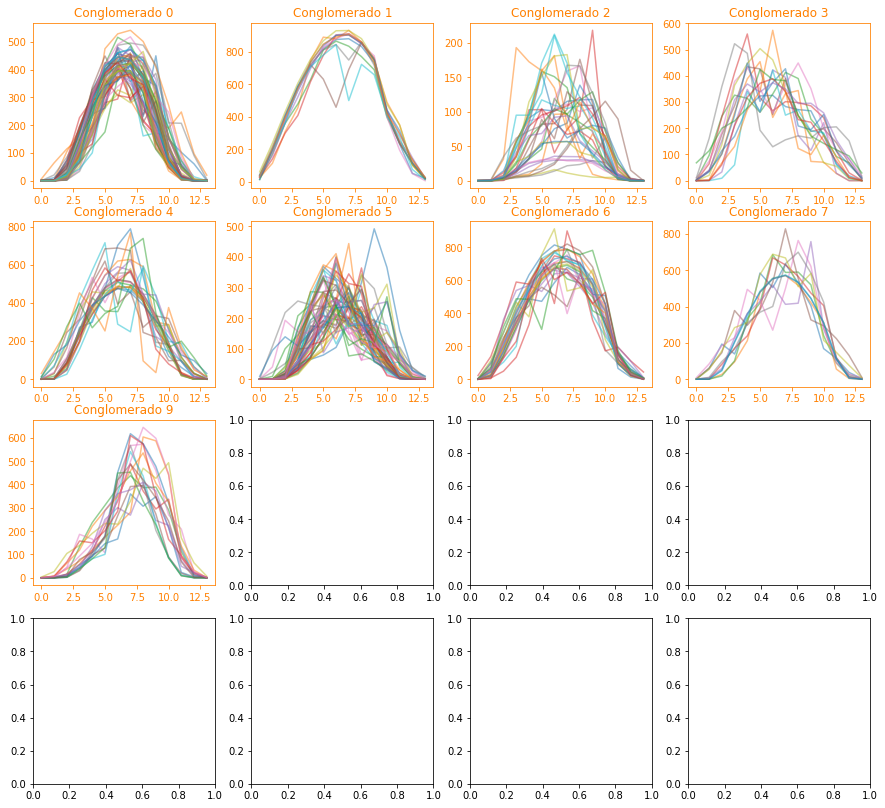

In [ ]:
print('X_train (KNN)')
print_patrones(list_series=X_train,list_categorias=knn_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_knn_train')

X_test (KNN)


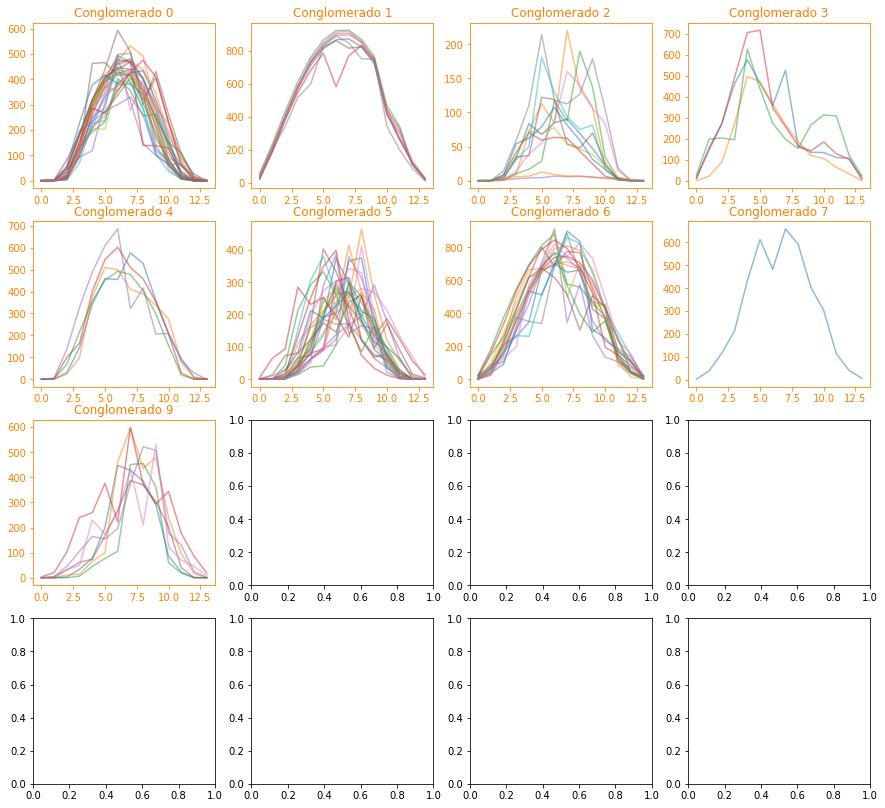

In [ ]:
print('X_test (KNN)')
print_patrones(list_series=X_test,list_categorias=knn_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_knn_test')

# **Radiación solar diaria**

In [ ]:
#https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/
model=ARIMA(x_total,order=(1,0,1))
model_fit=model.fit()

forecast_dx = model_fit.predict(start=550,end=650,dynamic=False)

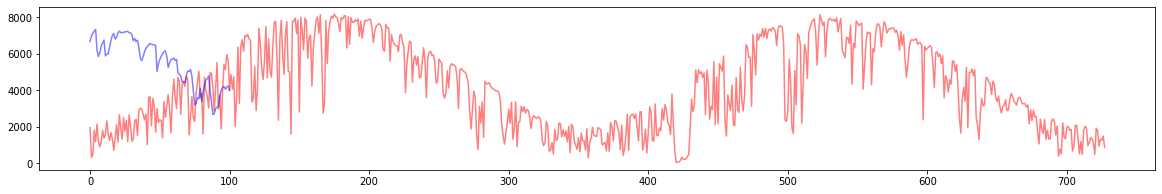

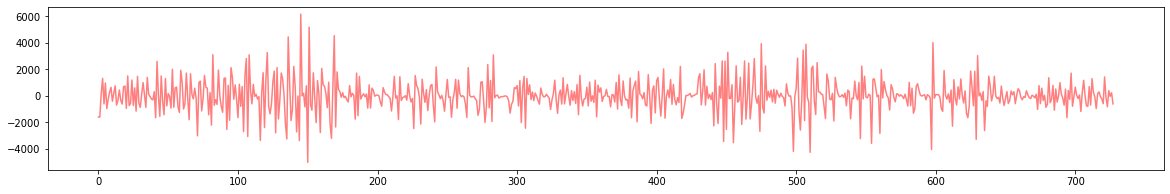

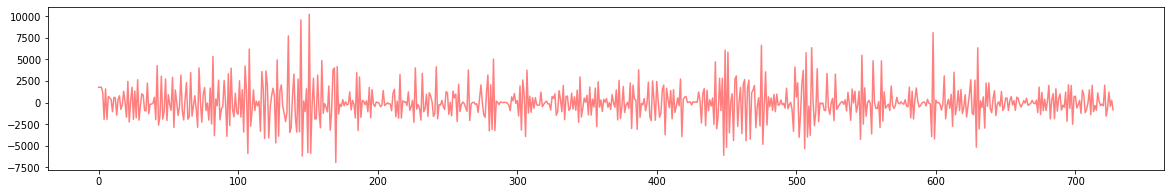

<Figure size 1440x216 with 0 Axes>

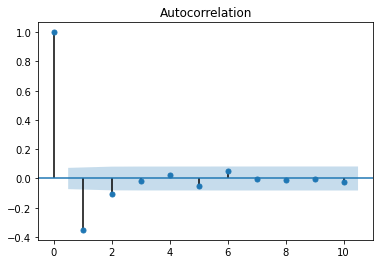

<Figure size 1440x216 with 0 Axes>

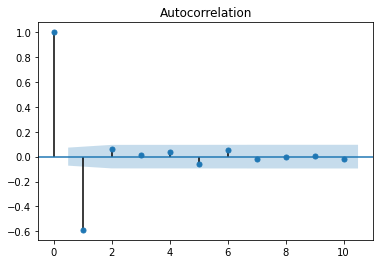

<Figure size 1440x216 with 0 Axes>

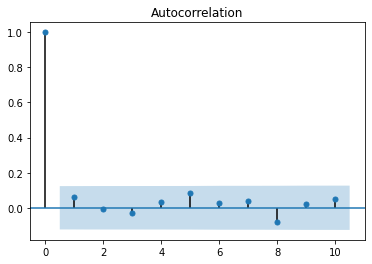

<Figure size 1440x216 with 0 Axes>

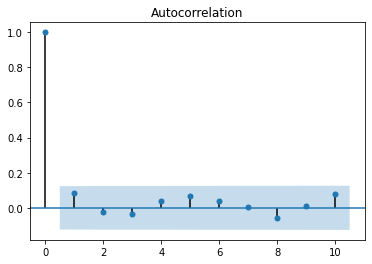

<Figure size 1584x360 with 0 Axes>

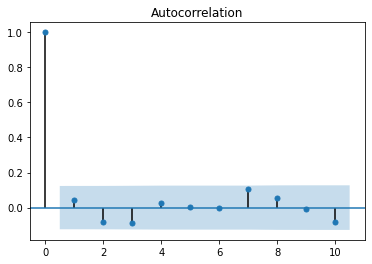

<Figure size 1440x216 with 0 Axes>

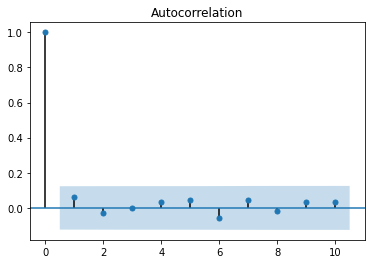

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(x_total,alpha=.5,color='red')
plt.plot(forecast_dx,alpha=.5,color='blue')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(dx_total,alpha=.5,color='red')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(ddx_total,alpha=.5,color='red')
plt.show()

plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(dx_total, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(ddx_total, lags=10)
plt.show()


plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(y_kmeans_train, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(glvq_pred_train, lags=10)
plt.show()
plt.figure(figsize=(22, 5))
sm.graphics.tsa.plot_acf(gm_pred_train, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(knn_pred_train, lags=10)
plt.show()

In [ ]:
model=ARIMA(gm_pred_train  ,order=(1,0,1))
model_fit=model.fit()

forecast_dx = model_fit.predict(start=200,end=300,dynamic=True)
print(forecast_dx)

ValueError: ignored

clusering (ventanas de diferente tamaño)

*   dynamic time warping (euclidiana)
*   matrix profile (  )
*   Abol de decisión o random forrest
*   standariza
*   piecewise agregation aproximation
*   sax simbolic aproximation 

https://matrixprofile.docs.matrixprofile.org/
https://matrixprofile.docs.matrixprofile.org/examples/Hierarchical_Clustering_Accelerometer_Walk_Stand_etc.html

# **A continuación intentaremos hacer regresión local**
(sin suerte)

In [ ]:
# Calcula los pesos y regresa una matriz diagonal con los pesos
def get_weight_exp(xo, X, kK): 
## k    : tamanio del vecindario (bandwidth)
## X    : Regresores
## xo   : punto donde se desea hacer la predicción.
    n = X.shape[0]             ## numero de datos
    weight = np.mat(np.eye(n)) ## Matriz de pesos identidad W.    
  # Cálculo de pesos para todos los datos de entrenamiento xi.
    for i in range(n): 
        xi = X[i] 
        d = (-2 * kK * kK) 
        weight[i, i] = np.exp(np.dot((xi-xo), (xi-xo).T)/d)
    return weight

def local_regression(X,Y,W,Xo):
    # W     --> Matriz diagonal de pesos
    # X     --> Regresores
    # xo    --> punto donde se desea hacer la predicción.
    Xt   = X.T  # Calcula transpuesta de X
    A    = np.matmul(Xt, np.matmul(W,X)) 
    A    = np.linalg.inv(A) # Calcula inversa de A
    B    = np.matmul(Xt, np.matmul(W,Y))
    beta = np.matmul(A,B)
    prediccion = np.matmul(Xo,beta)
    return prediccion

In [ ]:
X   = sm.add_constant(neighbors.T)
X_2 = sm.add_constant(neighbors2.T)
y   = apor[n-v:n]
y_real = apor[n-v+12:n+12]

k = 0 # Tamanio del vecindario
kmin = 1
kmax = 5
Y_local_list = []
Y_local      = []
aux = 0

for i in range(X.shape[0]):
    k = kmin
    flag = True
    while(flag==True):
        try:
            xo = X[[i]]
            W = get_weight_exp(xo, X, k)
            pred = local_regression(X, Y, W, xo)
            Y_local.append(pred.item(0))
            aux = pred.item(0)
        except:
            print("Sorry! Singular matrix found in position i=",str(i),"k=", k)
            k = k + 1
            if(k>kmax):                
                flag = False
                Y_local.append(0)
        else:
            flag = False 
            
Y_local_list.append(Y_local)
print(Y_local_list)